# Getting started: `pyutils` basics

## Introduction 

`pyutils` is a suite of tools designed to streamline Mu2e Python-based analysis tasks, enabling you to:

- Import and process data
- Handle selection cuts 
- Inspect and visualise data
- Perform vector operations
- Create publication-quality plots

Whether you're new to analysis at Mu2e or looking to improve your workflow, this tutorial will walk you through the basic features of `pyutils` through a demonstration of a simple analysis using `EventNtuple` data.

## Table of Contents
1. Setting up your environment
1. Importing data
1. Applying selection cuts
1. Inspecting your data
1. Performing vector operations
1. Plotting
1. Complete example

## <a id="setup"></a>1. Setting up your environment

First, we need to import the necessary external packages. Use the `mu2e_env` interactive kernel to make sure you have the packages you need, if not using a custom environment (see [tutorial](https://github.com/Mu2e/Tutorial/blob/main/EAF/Docs/06-TheMu2eEnvironment.md)). 

In [1]:
# Import external packages
import awkward as ak

Next, we need to set up our Python path to include the `pyutils` package.

In [2]:
# Set up your Python path
# Note: If you have muse set up, pyutils is already in your path
# Otherwise, append it explicitly
import sys 
sys.path.append("../../utils/pyutils") 

## 2. Processing data

The `pyprocess` module handles this, using `pyimport` and `pyread` as dependencies. The `Processor` class is your main tool for processing data.

Note that help information for all `pyutils` classes and functions can be accessed by running `help()`, e.g. `help(Processor)`. 

In [3]:
# Import the Procssor class
from pyprocess import Processor 

# Initialise the Importer with increased verbosity 
# verbosity=0 will only show errors
processor = Processor(verbosity=2)

# Define the path to our example file
file_name = "/exp/mu2e/data/users/sophie/ensembles/MDS1/MDS1av0.root"

# Define the branches we want to access
# For a complete list of available branches, see:
# https://github.com/Mu2e/EventNtuple/blob/main/doc/branches.md
# Also refer to ntuplehelper, available after mu2e setup EventNtuple
branches = ["trksegs"]

# Import the branches from the file
# This loads the data into memory and returns an awkward array
data = processor.process_data(
    file_name=file_name,
    branches=branches
)

[pyprocess] Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = False
	verbosity=2
[pyread] ✅ Opened /exp/mu2e/data/users/sophie/ensembles/MDS1/MDS1av0.root
[pyimport]  Accessing branches in tree:
name                 | typename                 | interpretation                                                                                      
---------------------+--------------------------+-----------------------------------------------------------------------------------------------------
trksegs              | std::vector<std::vect... | AsObjects(AsVector(True, AsVector(False, Model_mu2e_3a3a_TrkSegInfo)))
[pyimport] ✅ Imported branches
[pyimport]  Array structure:
28076 * {
    trksegs: var * var * struct[{
        mom: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT:

When running with high verbosity, you'll see detailed output about the structure of the imported data. 

## 3. Applying selection cuts
Once data is loaded, you can filter you data with selection cuts. The `Select` class from `pyselect` provides tools for this purpose.

In [4]:
# Import the Select class
from pyselect import Select 

# Initialise the selector with verbose output
selector = Select(verbosity=2)

# Create a mask to select track segments at the tracker entrance
# sid = 0 corresponds to the tracker entrance plane
at_trkent = selector.select_surface(
    data=data, 
    sid=0  # Select the tracker entrance
)

# Optional: add the mask to the data array (useful for verification)
data["at_trkent"] = at_trkent

# Apply the mask to create a new array with only track segments at the tracker entrance
trkent = data[at_trkent]

[pyselect] Initialised Select with verbosity = 2
[pyselect] Returning mask for trksegs with sid = 0 and sindex = 0


In this example, we're selecting track segments at the entrance to the tracker (sid = 0). 

 >**Note:** `Select` does not provide utilities for applying the mask to the data. This is a deliberate choice to enable the user to combine cuts as they like and to use different masking methods. 

## 4. Inspecting Your Data

After selecting your data, you can verify that the selection cuts are behaving as expected. The `Print` class from `pyprint` allows you to examine individual events before and after applying cuts.

In [5]:
# Import the Print class
from pyprint import Print

# Initialise the printer
# verbose=False is default and prevents overwhelming output with large arrays
# verbose=True prevents array truncation, for detailed debugging
printer = Print(verbose=False)

# Compare data before and after cuts
print("Before selection cuts:")
printer.print_n_events(data, n_events=1)

print("\nAfter selection cuts:")
printer.print_n_events(trkent, n_events=1)

[pyprint] Initialised Print with verbose = False and precision = 1
Before selection cuts:

[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
trksegs.mom.fCoordinates.fX: [[75.7, -74, 43.8, 101, -22.7, 120], ..., [-74.9, 70.8, -43.7, ..., 140, -114]]
trksegs.mom.fCoordinates.fY: [[84, -78.1, -96.4, 25.1, -144, 38.2], ..., [-82.9, 79.5, ..., -29.3, -50]]
trksegs.mom.fCoordinates.fZ: [[91.6, 97.9, 99.4, 100, 6.53, 73.2], ..., [-91.1, -97.1, ..., -10.6, -72.6]]
trksegs.pos.fCoordinates.fX: [[-35.5, 475, 543, 144, 420, 104], ..., [-31.7, 481, 543, 145, 113, 75.4]]
trksegs.pos.fCoordinates.fY: [[298, -178, 206, 402, 13.9, 355], [...], ..., [298, -165, 207, 401, -192, 344]]
trksegs.pos.fCoordinates.fZ: [[-2.59e+03, -1.63e+03, 10.1, 1.64e+03, -5.97e+03, -3.9e+03], [...], ..., [...]]
trksegs.time: [[1.63e+03, 1.64e+03, 1.65e+03, 1.65e+03, 1.6e+03, 1.63e+03], [...], ..., [...]]
trksegs.dmom: [[-0.153, 0, 0, 0, 0, 0], [-0.

This will show you:
- The data structure before applying the selection
- The data structure after applying the selection
- Confirmation that all selected track segments have sid = 0
- Confirmation that the at_trkent flag is True for all track segments

## 5. Performing Vector Operations

The `Vector` class from `pyvector` provides tools for common element wise vector operations on your array.

In [6]:
# Import the Vector class
from pyvector import Vector

# Initialise the vector processor
vector = Vector(verbosity=2)

# Calculate the momentum magnitude from the momentum vector components
# This creates a new array with the magnitudes
mom_mag = vector.get_mag(
    branch=trkent["trksegs"],
    vector_name="mom" # either "mom" or "pos" in EventNtuple
)

[pyvector] Initialised Vector with verbosity = 2
[pyvector] ✅ Created 3D 'mom' vector
28076 * var * var * Vector3D[
    x: float32,
    y: float32,
    z: float32
]
[pyvector] ✅ Got 'mom' magnitude
28076 * var * var * float32


The `get_mag()` function calculates the magnitude of a 3D vector, using the `vector` package.

## 6. Plotting

The `Plot` class from `pyplot` provides methods for creating publication-quality plots from flattened arrays. 

>**Note**: `pyplot` will be extended to allow plotting histogram objects directly. 

### 6.1 Creating a 1D Histogram

First, let's create a 1D histogram of the time distribution for track segments at the tracker entrance (the $t_{0}$):

[pyplot] Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyplot] ✅ Wrote:
	h1_time.png


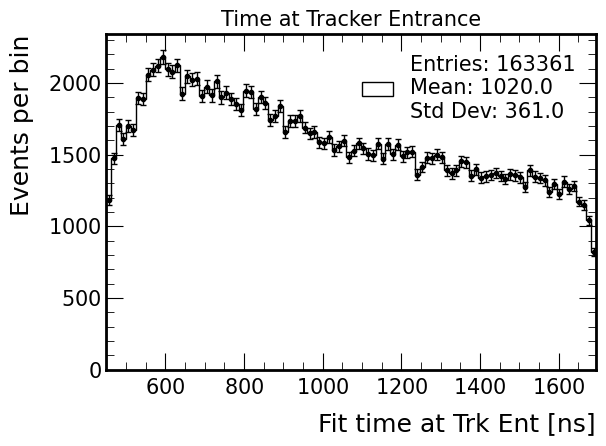

In [7]:
# Import the Plot class
from pyplot import Plot 

# Initialise the plotter
plotter = Plot()

# Flatten the array 
# ak.flatten with axis=None removes all nesting, so that the result is always a 1D array 
time_flat = ak.flatten(trkent["trksegs"]["time"], axis=None)

# Create a 1D histogram of track times
plotter.plot_1D(
    time_flat,               # Data to plot
    nbins=100,               # Number of bins
    xmin=450,                # Minimum x-axis value
    xmax=1695,               # Maximum x-axis value
    title="Time at Tracker Entrance",
    xlabel="Fit time at Trk Ent [ns]",
    ylabel="Events per bin",
    out_path='h1_time.png',  # Output file path
    stat_box=True,           # Show statistics box
    error_bars=True          # Show error bars
)

Again, to explore the full functionality of `pyutils` functions you can always run `help()`, as shown below:

In [8]:
help(plotter.plot_1D)

Help on method plot_1D in module pyplot:

plot_1D(array, nbins=100, xmin=-1.0, xmax=1.0, weights=None, title=None, xlabel=None, ylabel=None, col='black', leg_pos='best', out_path=None, dpi=300, log_x=False, log_y=False, norm_by_area=False, under_over=False, stat_box=True, stat_box_errors=False, error_bars=False, ax=None, show=True) method of pyplot.Plot instance
    Create a 1D histogram from an array of values.

    Args:
      array (np.ndarray): Input data array
      weights (np.ndarray, optional): Weights for each value
      nbins (int, optional): Number of bins. Defaults to 100
      xmin (float, optional): Minimum x-axis value. Defaults to -1.0
      xmax (float, optional): Maximum x-axis value. Defaults to 1.0
      title (str, optional): Plot title
      xlabel (str, optional): X-axis label
      ylabel (str, optional): Y-axis label
      col (str, optional): Histogram color. Defaults to 'black'
      leg_pos (str, optional): Legend position. Defaults to 'best'
      out_path

### 6.2 Creating a 2D Histogram

Now, let's create a 2D histogram to explore the relationship between momentum and time:

[pyplot] ✅  Wrote:
	h2_timevmom.png


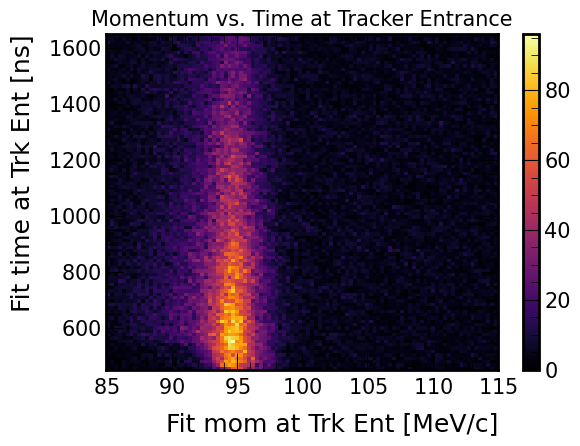

In [8]:
# Flatten the momentum magnitudes for plotting
mom_mag_flat = ak.flatten(mom_mag, axis=None)

# Create a 2D histogram of momentum vs. time
plotter.plot_2D(
    x=mom_mag_flat,           # x-axis data
    y=time_flat,              # y-axis data
    nbins_x=100,              # Number of x bins
    xmin=85,                  # Minimum x value
    xmax=115,                 # Maximum x value
    nbins_y=100,              # Number of y bins
    ymin=450,                 # Minimum y value
    ymax=1650,                # Maximum y value
    title="Momentum vs. Time at Tracker Entrance",
    xlabel="Fit mom at Trk Ent [MeV/c]",
    ylabel="Fit time at Trk Ent [ns]",
    out_path='h2_timevmom.png'
)

This 2D plot shows the relationship between track momentum and time at the entrance to the tracker.

## 7. Complete example

To put everything together, here is a complete example that demonstrates importing data, applying selections, performing vector operations, and creating visualisations.

In [9]:
import awkward as ak
import sys
sys.path.append("../../utils/pyutils")

# Import data
from pyimport import Importer
importer = Importer(verbosity=1)
data = importer.import_file(
    file_name="/exp/mu2e/data/users/sophie/ensembles/MDS1/MDS1av0.root",
    branches=["trksegs"]
)

# Apply selection
from pyselect import Select
selector = Select(verbosity=1)
at_trkent = selector.select_surface(data=data, sid=0)
trkent = data[at_trkent]

# Calculate momentum magnitude
from pyvector import Vector
vector = Vector(verbosity=1)
mom_mag = vector.get_mag(branch=trkent["trksegs"], vector_name="mom")

# Create visualizations
from pyplot import Plot
plotter = Plot()

# Flatten arrays for plotting
time_flat = ak.flatten(trkent["trksegs"]["time"], axis=None)
mom_mag_flat = ak.flatten(mom_mag, axis=None)

# 1D Histogram of time
plotter.plot_1D(
    time_flat,
    nbins=100,
    xmin=450,
    xmax=1695,
    title="Time Distribution at Tracker Entrance",
    xlabel="Time [ns]",
    ylabel="Events",
    out_path='time_distribution.png'
)

# 2D Histogram of momentum vs time
plotter.plot_2D(
    x=mom_mag_flat,
    y=time_flat,
    nbins_x=100,
    xmin=85,
    xmax=115,
    nbins_y=100,
    ymin=450,
    ymax=1650,
    title="Momentum vs. Time at Tracker Entrance",
    xlabel="Momentum [MeV/c]",
    ylabel="Time [ns]",
    out_path='momentum_vs_time.png'
)

TypeError: Importer.__init__() missing 2 required positional arguments: 'file_name' and 'branches'